# 1 Load Sample Data

In [183]:
# Setting up packages for data manipulation and machine learning
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Link to the dataset:  
# https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting

path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/alcohol_sales/BeerWineLiquor.csv"
df = pd.read_csv(path)
df.head()

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


# 2 Check if the data is stationary

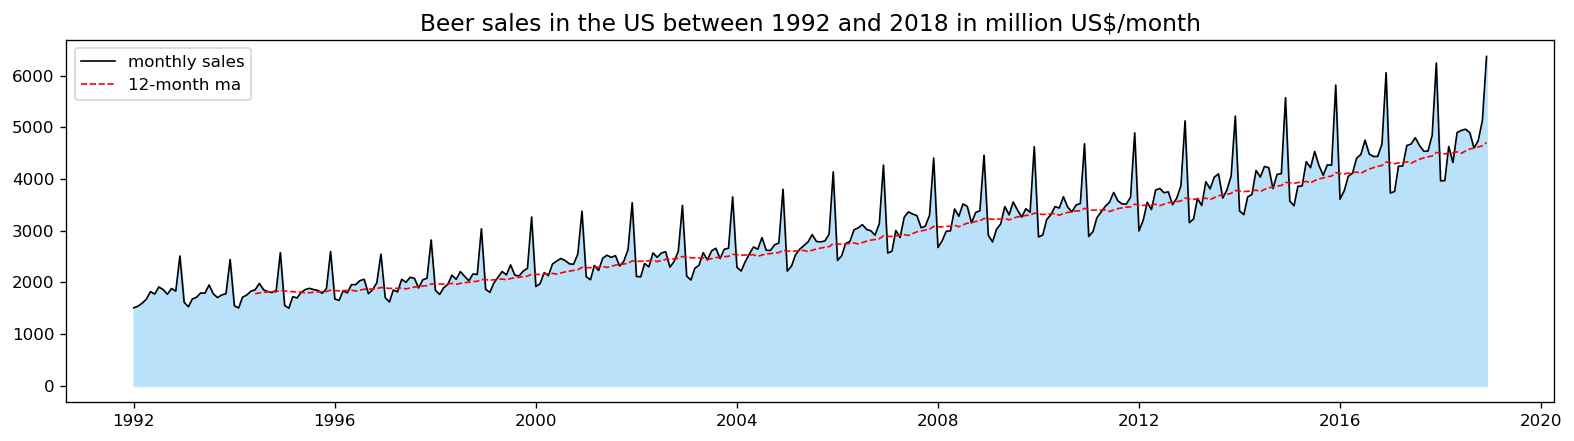

(0.019143247561160443, False)


In [184]:
def check_stationarity(dates, sales, title_string):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(16, 4))
    plt.title(title_string, fontsize=14)
    plt.plot(dates, sales, label='monthly sales', color="black", linewidth=1.0)
    
    ma = sales.rolling(window=30).mean()
    plt.plot(dates, ma, label='12-month ma', color="red", linewidth=1.0, linestyle='--')
    ax.fill_between(dates, 0, sales, color='#b9e1fa')
    
    plt.legend()
    plt.show()
    
    sales = sales.dropna()
    # Perform an Ad Fuller Test
    # the default alpha = .05 stands for a 95% confidence interval
    adf_test = pm.arima.ADFTest(alpha = 0.05) 
    print(adf_test.should_diff(sales))
    
df_sales = df['beer']
df_dates = pd.to_datetime(df['date']) 
title = "Beer sales in the US between 1992 and 2018 in million US$/month"
check_stationarity(df_dates, df_sales, title)

# 3 Exemplary Differencing 

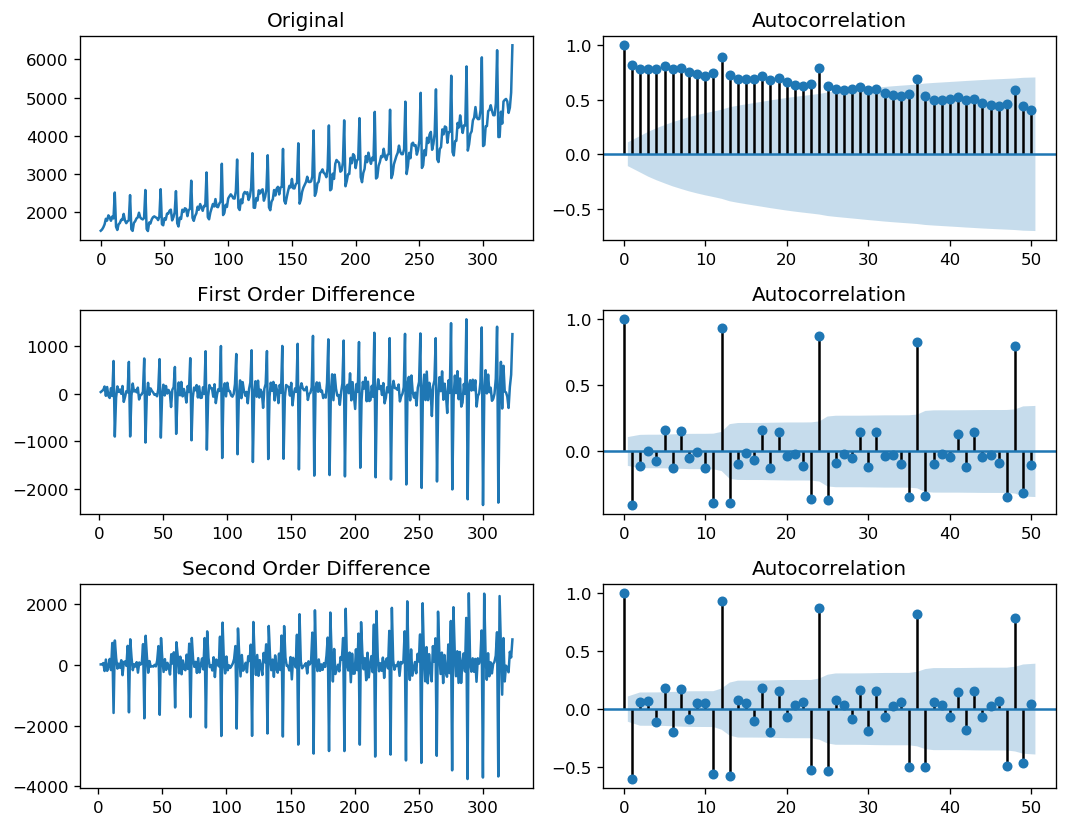

In [185]:
# Non-seasonal part

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3,2, sharex=False)

# First Difference
axes[0, 0].plot(df_sales)
axes[0, 0].set_title('Original')
plot_acf(df_sales, lags=50, ax=axes[0, 1])

# First Difference
df_first_diff = df_sales.diff().dropna()
axes[1, 0].plot(df_first_diff)
axes[1, 0].set_title('First Order Difference')
plot_acf(df_first_diff, lags=50, ax=axes[1, 1])

# Second Difference
df_second_diff = df_sales.diff().diff().dropna()
axes[2, 0].plot(df_second_diff)
axes[2, 0].set_title('Second Order Difference')
plot_acf(df_second_diff, lags=50, ax=axes[2, 1])
plt.tight_layout()
plt.show()

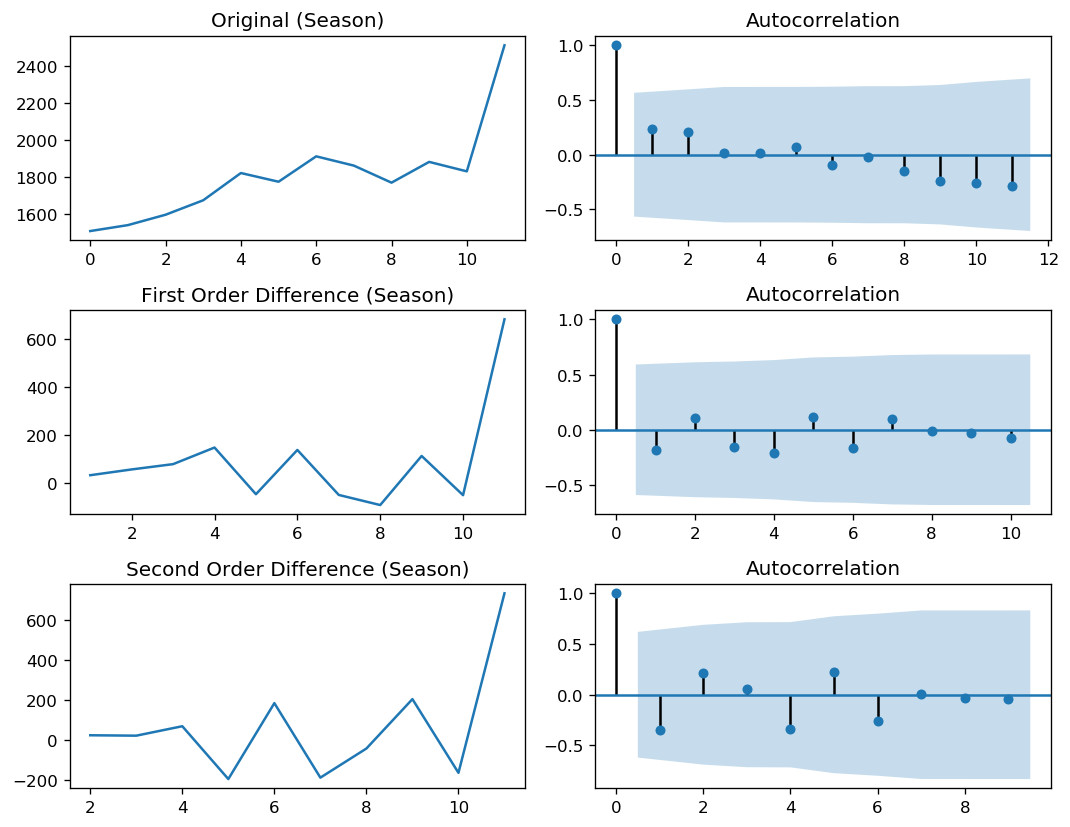

In [186]:
# Seasonal part

# Create the difference of the time-series
df_sales_s = df_sales[0:12]

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3,2, sharex=False)

# First Difference
axes[0, 0].plot(df_sales_s)
axes[0, 0].set_title('Original (Season)')
plot_acf(df_sales_s, ax=axes[0, 1])

# First Difference
df_sales_s_first_diff = df_sales_s.diff().dropna()
axes[1, 0].plot(df_sales_s_first_diff)
axes[1, 0].set_title('First Order Difference (Season)')
plot_acf(df_sales_s_first_diff, ax=axes[1, 1])

# Second Difference
df_sales_s_second_diff = df_sales_s.diff().diff().dropna()
axes[2, 0].plot(df_sales_s_second_diff)
axes[2, 0].set_title('Second Order Difference (Season)')
plot_acf(df_sales_s_second_diff, ax=axes[2, 1])
plt.tight_layout()
plt.show()

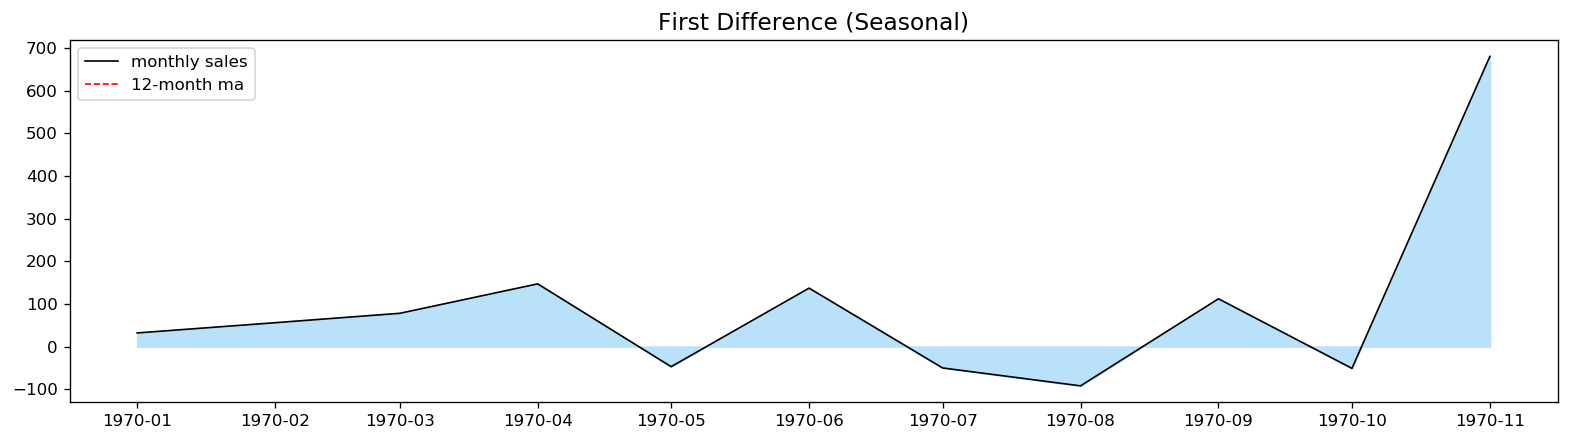

(0.99, True)


In [187]:
# Check if the First difference is stationary
df_dates_first_s = pd.date_range(df_sales_s_first_diff.iloc[1], periods=11, freq='MS') 

title = "First Difference (Seasonal)"
check_stationarity(df_dates_first_s, df_sales_s_first_diff, title)

# 4 Use Auto-ARIMA to find an optimal model

In [188]:
# p, d, q Son-seasonal part of the model
# P, D, Q Sesonal part of the model

model_fit = pm.auto_arima(df_sales, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12, # m=number of observations per Year
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=3658.232, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3762.131, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3723.063, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3737.676, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4021.999, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3661.769, Time=0.25 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=3742.725, Time=1.21 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=3642.869, Time=2.30 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=3739.665, Time=1.40 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=3720.427, Time=1.45 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=3636.484, Time=2.91 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=3646.445, Time=1.05 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=3643.442, Time=3.31 sec
 ARIMA(2,0,1)(1,1,1)[12]

In [189]:
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  324
Model:             SARIMAX(3, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1804.636
Date:                                 Sun, 28 Mar 2021   AIC                           3623.272
Time:                                         00:56:33   BIC                           3649.473
Sample:                                              0   HQIC                          3633.744
                                                 - 324                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.8487      8.094      2.700      0.007       5.986      37

# 5 Simulate the time-series

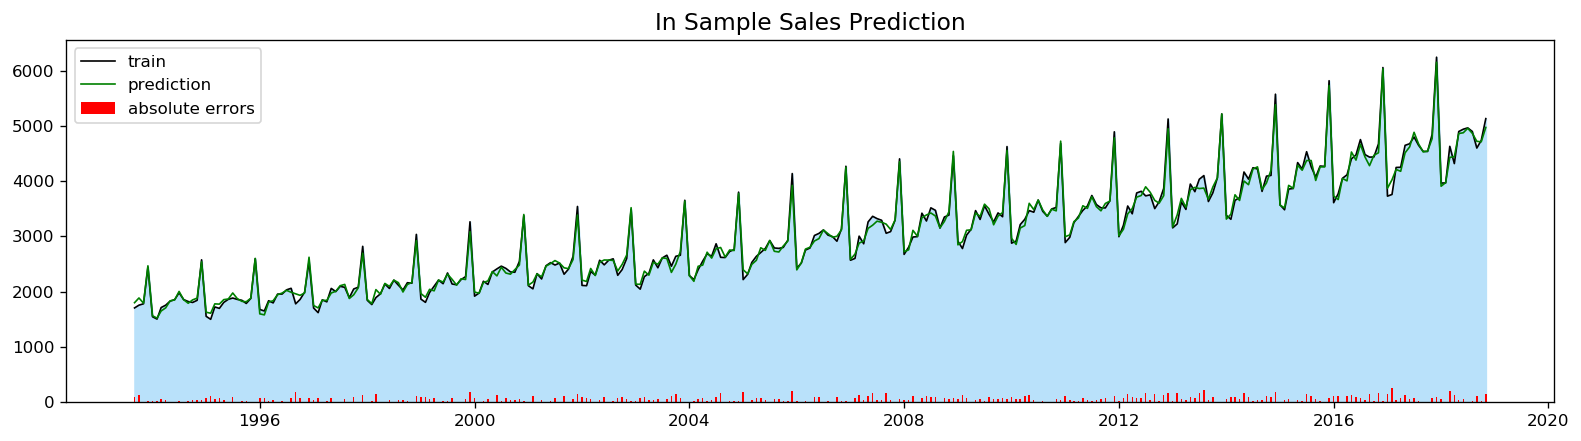

In [190]:
# The dynamic keyword affects in-sample prediction. If dynamic is False, then the in-sample lagged values are used for prediction. 
# If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables. 
# The first forecasted value is start.
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima

#shorten the time-series so that we have a full overlap between predictions and the original data
df_dates_short = df_dates[20: -1]
df_sales_short = df_sales[20: -1]
df_pred_short = pred[20: -1]
diff = abs(df_sales_short - df_pred_short)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 4))
plt.title("In Sample Sales Prediction", fontsize=14)
plt.plot(df_dates_short, df_sales_short, label='train', color="black", linewidth=1.0)
plt.plot(df_dates_short, df_pred_short, label='prediction', color="green", linewidth=1.0)
ax.fill_between(df_dates_short, 0, df_sales_short, color='#b9e1fa')

plt.bar(df_dates_short, diff, width=10, color='red', label='absolute errors')
plt.legend()
plt.show()

# 6 Measure Performance

In [191]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(df_sales_short, df_pred_short)/ df_sales_short))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(df_sales_short, df_pred_short)/ df_sales_short)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 2.09 %
Median Absolute Percentage Error (MDAPE): 1.72 %


# 7 Make predictions and visualize them

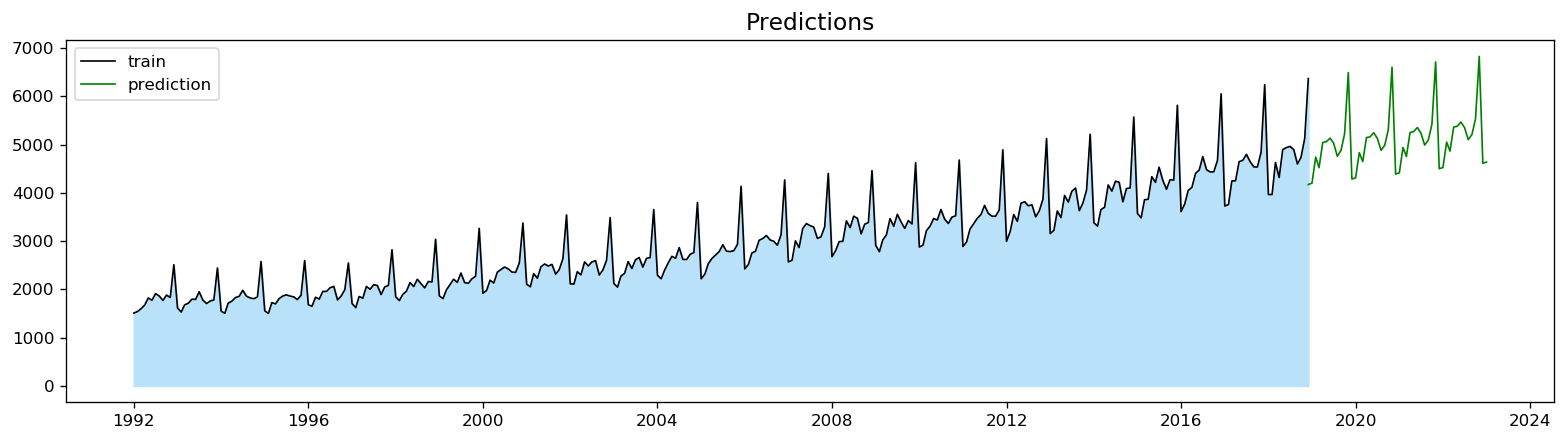

In [192]:
# Generate prediction for n periods, starting from the last date of the regular time-series
start = df_sales.size
n_periods = 50
pred = model_fit.predict(start=start, n_periods=n_periods, dynamic=False)

# Generate the prediction index from periods
# we need to set the frequency to always get the first day of the Month 
pred_index = pd.date_range(df_dates.iloc[-1], periods=n_periods, freq='MS') 

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 4))
plt.title("Predictions", fontsize=14)
plt.plot(df_dates, df_sales, label='train', color="black", linewidth=1.0)
plt.plot(pred_index, pred, label='prediction', color="green", linewidth=1.0)
ax.fill_between(df_dates, 0, df_sales, color='#b9e1fa')
plt.legend()
plt.show()